In [1]:
from torch.utils.tensorboard import SummaryWriter
import argparse
import pickle
import random
import time
import gym
import d4rl
import torch
import numpy as np
import matplotlib.pyplot as plt

import utils
from replay_buffer import ReplayBuffer
from lamb import Lamb
from stable_baselines3.common.vec_env import SubprocVecEnv
from pathlib import Path
from data import create_dataloader
from decision_transformer.models.decision_transformer import DecisionTransformer
from evaluation import create_vec_eval_episodes_fn, vec_evaluate_episode_rtg
from trainer import SequenceTrainer
from logger import Logger

from env import make_pytorch_env

#MAX_EPISODE_LEN = 2000 # 4000 # 2000 # 4000 # Warning: there is a similar variable in data.py! 

/home/gabriel/CARLA_0.9.8/PythonAPI/carla/dist/carla-0.9.8-py3.5-linux-x86_64.egg/carla/libcarla.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
pybullet build time: May 20 2022 19:44:17


In [2]:
import sys
sys.argv = ['']

parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=10)
parser.add_argument("--env", type=str, default="drone_dataset")

# model options
context_length = 80 #1200 # 1500 # 550 #330
## Training Context Length K: (default: 20)
parser.add_argument("--K", type=int, default=context_length) 
## Embedding dimension: (default: 512)
parser.add_argument("--embed_dim", type=int, default=512)
## Number of Layers: (default: 4)
parser.add_argument("--n_layer", type=int, default=6)
## Number of Attention Heads: (default: 4)
parser.add_argument("--n_head", type=int, default=8)
## Nonlinearity function: 
parser.add_argument("--activation_function", type=str, default="relu")
## Dropout:
parser.add_argument("--dropout", type=float, default=0.1)
## Evaluating Context Length K: 
parser.add_argument("--eval_context_length", type=int, default=context_length)
## Positional embedding: absolute ordering
parser.add_argument("--ordering", type=int, default=0) # 0

# shared evaluation options
# g_eval: (default: 3600)
parser.add_argument("--eval_rtg", type=int, default=3600)
parser.add_argument("--num_eval_episodes", type=int, default=10)

# shared training options
parser.add_argument("--init_temperature", type=float, default=0.1)
## Batch Size: (default: 256)
parser.add_argument("--batch_size", type=int, default=256)
parser.add_argument("--learning_rate", "-lr", type=float, default=3e-4)
parser.add_argument("--weight_decay", "-wd", type=float, default=5e-4)
## Warmup Steps: (default: 10000)
parser.add_argument("--warmup_steps", type=int, default=10000)

# pretraining options
parser.add_argument("--max_pretrain_iters", type=int, default=1)
parser.add_argument("--num_updates_per_pretrain_iter", type=int, default=5000)

# finetuning options
parser.add_argument("--max_online_iters", type=int, default=2000)
parser.add_argument("--online_rtg", type=int, default=7200)
## Number of Online Rollouts: (default: 1)
parser.add_argument("--num_online_rollouts", type=int, default=5)
parser.add_argument("--replay_size", type=int, default=1000)
parser.add_argument("--num_updates_per_online_iter", type=int, default=300)
parser.add_argument("--eval_interval", type=int, default=10)

# environment options
parser.add_argument("--device", type=str, default="cuda")
parser.add_argument("--log_to_tb", "-w", type=bool, default=True)
parser.add_argument("--save_dir", type=str, default="./exp")
parser.add_argument("--exp_name", type=str, default="default")

# general options
parser.add_argument("--max_episode_len", type=int, default=2000)

# Add for fast Debbuging
'''
parser.add_argument("--K", type=int, default=1)
parser.add_argument("--embed_dim", type=int, default=4)
parser.add_argument("--n_layer", type=int, default=2)
parser.add_argument("--n_head", type=int, default=2)
parser.add_argument("--eval_context_length", type=int, default=1)
parser.add_argument("--eval_rtg", type=int, default=600)
parser.add_argument("--num_eval_episodes", type=int, default=2)
parser.add_argument("--batch_size", type=int, default=4)
parser.add_argument("--warmup_steps", type=int, default=10)
parser.add_argument("--num_updates_per_pretrain_iter", type=int, default=500)
parser.add_argument("--max_online_iters", type=int, default=500)
parser.add_argument("--online_rtg", type=int, default=720)
'''



args = parser.parse_args()

In [3]:
class Experiment:
    def __init__(self, variant):

        self.state_dim, self.act_dim, self.action_range = self._get_env_spec(variant)
        self.offline_trajs, self.state_mean, self.state_std = self._load_dataset(
            variant["env"]
        )
        # initialize by offline trajs
        self.replay_buffer = ReplayBuffer(variant["replay_size"], self.offline_trajs)

        self.aug_trajs = []

        self.device = variant.get("device", "cuda")
        self.target_entropy = -self.act_dim
        self.model = DecisionTransformer(
            state_dim=self.state_dim,
            act_dim=self.act_dim,
            action_range=self.action_range,
            max_length=variant["K"],
            eval_context_length=variant["eval_context_length"],
            max_ep_len=variant["max_episode_len"],
            hidden_size=variant["embed_dim"],
            n_layer=variant["n_layer"],
            n_head=variant["n_head"],
            n_inner=4 * variant["embed_dim"],
            activation_function=variant["activation_function"],
            n_positions=1024,
            n_ctx=3*variant["K"],
            resid_pdrop=variant["dropout"],
            attn_pdrop=variant["dropout"],
            stochastic_policy=True,
            ordering=variant["ordering"],
            init_temperature=variant["init_temperature"],
            target_entropy=self.target_entropy,
        ).to(device=self.device)

        self.optimizer = Lamb(
            self.model.parameters(),
            lr=variant["learning_rate"],
            weight_decay=variant["weight_decay"],
            eps=1e-8,
        )
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer, lambda steps: min((steps + 1) / variant["warmup_steps"], 1)
        )

        self.log_temperature_optimizer = torch.optim.Adam(
            [self.model.log_temperature],
            lr=1e-4,
            betas=[0.9, 0.999],
        )

        # track the training progress and
        # training/evaluation/online performance in all the iterations
        self.pretrain_iter = 0
        self.online_iter = 0
        self.total_transitions_sampled = 0
        self.variant = variant
        self.reward_scale = 1.0 #  if "antmaze" in variant["env"] else 0.02 # almost the same as dividing by 42
        self.logger = Logger(variant)

    def _get_env_spec(self, variant):
        #####env = gym.make(variant["env"])
        env = make_pytorch_env(args)
        #env.max_step = MAX_EPISODE_LEN
        state_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        #action_range = [-0.999999, 0.999999]
        
        action_range = [
            float(env.action_space.low.min()) + 1e-6,
            float(env.action_space.high.max()) - 1e-6,
        ]
        
        print("action_range: {}".format(action_range))
        env.close()
        return state_dim, act_dim, action_range

    def _save_model(self, path_prefix, is_pretrain_model=False):
        to_save = {
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict(),
            "pretrain_iter": self.pretrain_iter,
            "online_iter": self.online_iter,
            "args": self.variant,
            "total_transitions_sampled": self.total_transitions_sampled,
            "np": np.random.get_state(),
            "python": random.getstate(),
            "pytorch": torch.get_rng_state(),
            "log_temperature_optimizer_state_dict": self.log_temperature_optimizer.state_dict(),
        }

        with open(f"{path_prefix}/model.pt", "wb") as f:
            torch.save(to_save, f)
        print(f"\nModel saved at {path_prefix}/model.pt")

        if is_pretrain_model:
            with open(f"{path_prefix}/pretrain_model.pt", "wb") as f:
                torch.save(to_save, f)
            print(f"Model saved at {path_prefix}/pretrain_model.pt")

    def _load_model(self, path_prefix):
        if Path(f"{path_prefix}/model.pt").exists():
            with open(f"{path_prefix}/model.pt", "rb") as f:
                checkpoint = torch.load(f)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
            self.log_temperature_optimizer.load_state_dict(
                checkpoint["log_temperature_optimizer_state_dict"]
            )
            self.pretrain_iter = checkpoint["pretrain_iter"]
            self.online_iter = checkpoint["online_iter"]
            self.total_transitions_sampled = checkpoint["total_transitions_sampled"]
            np.random.set_state(checkpoint["np"])
            random.setstate(checkpoint["python"])
            torch.set_rng_state(checkpoint["pytorch"])
            print(f"Model loaded at {path_prefix}/model.pt")

    def _load_dataset(self, env_name):

        dataset_path = f"./data/{env_name}.pkl"
        with open(dataset_path, "rb") as f:
            trajectories = pickle.load(f)

        states, traj_lens, returns = [], [], []
        for path in trajectories:
            states.append(path["observations"])
            traj_lens.append(len(path["observations"]))
            returns.append(path["rewards"].sum())
        traj_lens, returns = np.array(traj_lens), np.array(returns)

        # used for input normalization
        states = np.concatenate(states, axis=0)
        state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        num_timesteps = sum(traj_lens)

        print("=" * 50)
        print(f"Starting new experiment: {env_name}")
        print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
        print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
        print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
        plt.plot(returns)
        plt.show()
        print(f"Average length: {np.mean(traj_lens):.2f}, std: {np.std(traj_lens):.2f}")
        print(f"Max length: {np.max(traj_lens):.2f}, min: {np.min(traj_lens):.2f}")
        print("=" * 50)

        sorted_inds = np.argsort(returns)  # lowest to highest
        num_trajectories = 1
        timesteps = traj_lens[sorted_inds[-1]]
        ind = len(trajectories) - 2
        while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
            timesteps += traj_lens[sorted_inds[ind]]
            num_trajectories += 1
            ind -= 1
        sorted_inds = sorted_inds[-num_trajectories:]
        trajectories = [trajectories[ii] for ii in sorted_inds]

        return trajectories, state_mean, state_std

    def _augment_trajectories(
        self,
        online_envs,
        target_explore,
        n,
        randomized=False,
    ):

        max_ep_len = self.variant["max_episode_len"]

        with torch.no_grad():
            # generate init state
            target_return = [target_explore * self.reward_scale] * online_envs.num_envs

            returns, lengths, trajs = vec_evaluate_episode_rtg(
                online_envs,
                self.state_dim,
                self.act_dim,
                self.model,
                max_ep_len=max_ep_len,
                reward_scale=self.reward_scale,
                target_return=target_return,
                mode="normal",
                state_mean=self.state_mean,
                state_std=self.state_std,
                device=self.device,
                use_mean=False,
            )

        self.replay_buffer.add_new_trajs(trajs)
        self.aug_trajs += trajs
        self.total_transitions_sampled += np.sum(lengths)

        return {
            "aug_traj/return": np.mean(returns),
            "aug_traj/length": np.mean(lengths),
        }

    def pretrain(self, eval_envs, loss_fn):
        print("\n\n\n*** Pretrain ***")
        print("----------------")
        print("eval_envs: {}".format(eval_envs))
        print("loss_fn: {}".format(loss_fn))
        
        eval_fns = [
            create_vec_eval_episodes_fn(
                vec_env=eval_envs,
                eval_rtg=self.variant["eval_rtg"],
                state_dim=self.state_dim,
                act_dim=self.act_dim,
                state_mean=self.state_mean,
                state_std=self.state_std,
                device=self.device,
                use_mean=True,
                reward_scale=self.reward_scale,
                max_episode_len = self.variant["max_episode_len"],
            )
        ]

        trainer = SequenceTrainer(
            model=self.model,
            optimizer=self.optimizer,
            log_temperature_optimizer=self.log_temperature_optimizer,
            scheduler=self.scheduler,
            device=self.device,
        )

        writer = (
            SummaryWriter(self.logger.log_path) if self.variant["log_to_tb"] else None
        )
        while self.pretrain_iter < self.variant["max_pretrain_iters"]:
            # in every iteration, prepare the data loader
            dataloader = create_dataloader(
                trajectories=self.offline_trajs,
                num_iters=self.variant["num_updates_per_pretrain_iter"],
                batch_size=self.variant["batch_size"],
                max_len=self.variant["K"],
                state_dim=self.state_dim,
                act_dim=self.act_dim,
                state_mean=self.state_mean,
                state_std=self.state_std,
                reward_scale=self.reward_scale,
                action_range=self.action_range,
                max_episode_len = self.variant["max_episode_len"],
            )

            train_outputs = trainer.train_iteration(
                loss_fn=loss_fn,
                dataloader=dataloader,
            )
            eval_outputs, eval_reward = self.evaluate(eval_fns)
            outputs = {"time/total": time.time() - self.start_time}
            outputs.update(train_outputs)
            outputs.update(eval_outputs)
            self.logger.log_metrics(
                outputs,
                iter_num=self.pretrain_iter,
                total_transitions_sampled=self.total_transitions_sampled,
                writer=writer,
            )

            self._save_model(
                path_prefix=self.logger.log_path,
                is_pretrain_model=True,
            )

            self.pretrain_iter += 1

    def evaluate(self, eval_fns):
        eval_start = time.time()
        self.model.eval()
        outputs = {}
        for eval_fn in eval_fns:
            o = eval_fn(self.model)
            outputs.update(o)
        outputs["time/evaluation"] = time.time() - eval_start

        eval_reward = outputs["evaluation/return_mean_gm"]
        return outputs, eval_reward

    def online_tuning(self, online_envs, eval_envs, loss_fn):

        print("\n\n\n*** Online Finetuning ***")

        trainer = SequenceTrainer(
            model=self.model,
            optimizer=self.optimizer,
            log_temperature_optimizer=self.log_temperature_optimizer,
            scheduler=self.scheduler,
            device=self.device,
        )
        eval_fns = [
            create_vec_eval_episodes_fn(
                vec_env=eval_envs,
                eval_rtg=self.variant["eval_rtg"],
                state_dim=self.state_dim,
                act_dim=self.act_dim,
                state_mean=self.state_mean,
                state_std=self.state_std,
                device=self.device,
                use_mean=True,
                reward_scale=self.reward_scale,
                max_episode_len = self.variant["max_episode_len"],
            )
        ]
        writer = (
            SummaryWriter(self.logger.log_path) if self.variant["log_to_tb"] else None
        )
        while self.online_iter < self.variant["max_online_iters"]:

            outputs = {}
            augment_outputs = self._augment_trajectories(
                online_envs,
                self.variant["online_rtg"],
                n=self.variant["num_online_rollouts"],
            )
            outputs.update(augment_outputs)

            dataloader = create_dataloader(
                trajectories=self.replay_buffer.trajectories,
                num_iters=self.variant["num_updates_per_online_iter"],
                batch_size=self.variant["batch_size"],
                max_len=self.variant["K"],
                state_dim=self.state_dim,
                act_dim=self.act_dim,
                state_mean=self.state_mean,
                state_std=self.state_std,
                reward_scale=self.reward_scale,
                action_range=self.action_range,
                max_episode_len = self.variant["max_episode_len"],
            )

            # finetuning
            is_last_iter = self.online_iter == self.variant["max_online_iters"] - 1
            if (self.online_iter + 1) % self.variant[
                "eval_interval"
            ] == 0 or is_last_iter:
                evaluation = True
            else:
                evaluation = False

            train_outputs = trainer.train_iteration(
                loss_fn=loss_fn,
                dataloader=dataloader,
            )
            outputs.update(train_outputs)

            if evaluation:
                eval_outputs, eval_reward = self.evaluate(eval_fns)
                outputs.update(eval_outputs)

            outputs["time/total"] = time.time() - self.start_time

            # log the metrics
            self.logger.log_metrics(
                outputs,
                iter_num=self.pretrain_iter + self.online_iter,
                total_transitions_sampled=self.total_transitions_sampled,
                writer=writer,
            )

            self._save_model(
                path_prefix=self.logger.log_path,
                is_pretrain_model=False,
            )

            self.online_iter += 1

    def __call__(self):

        utils.set_seed_everywhere(args.seed)

        import d4rl

        def loss_fn(
            a_hat_dist,     # action_preds
            a,              # action_target
            attention_mask, # padding_mask
            entropy_reg,    # self.model.temperature().detach()
        ):
            # a_hat is a SquashedNormal Distribution
            log_likelihood = a_hat_dist.log_likelihood(a)[attention_mask > 0].mean()
            
            entropy = a_hat_dist.entropy().mean()
            loss = -(log_likelihood + entropy_reg * entropy)
            
            '''
            print("a_hat_dist : {}".format(a_hat_dist))
            print("a : {}".format(a))
            torch.save(a,"a.pt")
            print("a_hat_dist.log_likelihood(a) : {}".format(a_hat_dist.log_likelihood(a)))
            #print("attention_mask : {}".format(attention_mask))
            print("log_likelihood: {}".format(log_likelihood))
            print("loss inside jupyter: {} of type: {}".format(loss,type(loss)))
            '''
            
            return (
                loss,
                -log_likelihood,
                entropy,
            )

        def get_env_builder(seed, env_name, target_goal=None):
            def make_env_fn():
                import d4rl

                #####env = gym.make(env_name)
                env = make_pytorch_env(args)
                #env.max_step = MAX_EPISODE_LEN
                env.seed(seed)
                '''
                if hasattr(env.env, "wrapped_env"):
                    env.env.wrapped_env.seed(seed)
                elif hasattr(env.env, "seed"):
                    env.env.seed(seed)
                else:
                    pass
                '''
                '''
                env.action_space.seed(seed)
                env.observation_space.seed(seed)
                '''

                if target_goal:
                    env.set_target_goal(target_goal)
                    print(f"Set the target goal to be {env.target_goal}")
                return env

            return make_env_fn

        print("\n\nMaking Eval Env.....")
        env_name = self.variant["env"]
        if "antmaze" in env_name:
            env = gym.make(env_name)
            target_goal = env.target_goal
            env.close()
            print(f"Generated the fixed target goal: {target_goal}")
        else:
            target_goal = None
        eval_envs = SubprocVecEnv(
            [
                get_env_builder(i, env_name=env_name, target_goal=target_goal)
                for i in range(self.variant["num_eval_episodes"])
            ]
        )

        self.start_time = time.time()
        
        if self.variant["max_pretrain_iters"]:
            self.pretrain(eval_envs, loss_fn)
        
        if self.variant["max_online_iters"]:
            print("\n\nMaking Online Env.....")
            online_envs = SubprocVecEnv(
                [
                    get_env_builder(i + 100, env_name=env_name, target_goal=target_goal)
                    for i in range(self.variant["num_online_rollouts"])
                ]
            )
            self.online_tuning(online_envs, eval_envs, loss_fn)
            online_envs.close()

        eval_envs.close()

action_range: [-0.999999, 0.999999]
Starting new experiment: drone_dataset
1254 trajectories, 1971662 timesteps found
Average return: 87.79, std: 20.84
Max return: 124.19, min: 30.10


/home/gabriel/miniconda3/envs/odt/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


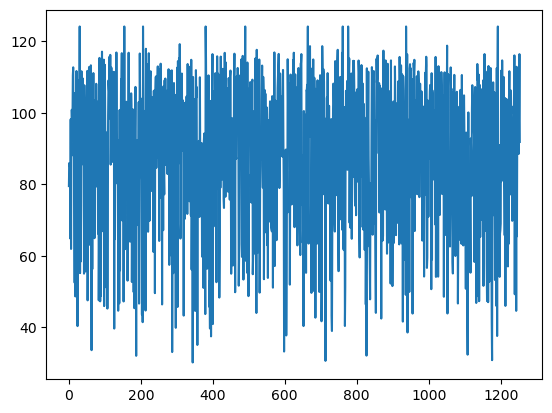

Average length: 1572.30, std: 325.37
Max length: 2000.00, min: 920.00
{'n_layer': 6, 'n_head': 8, 'n_inner': 2048, 'activation_function': 'relu', 'n_positions': 1024, 'n_ctx': 240, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1}
Experiment log path: ./exp/2023.04.17/233151-default


In [4]:
utils.set_seed_everywhere(args.seed)
experiment = Experiment(vars(args))

#print("=" * 50)
#experiment()

In [5]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [6]:
import torch
import numpy as np

from env import make_pytorch_env
from decision_transformer.models.decision_transformer import DecisionTransformer


In [7]:
vec_env = make_pytorch_env(args)

In [8]:
vec_env

In [9]:
state = vec_env.reset()


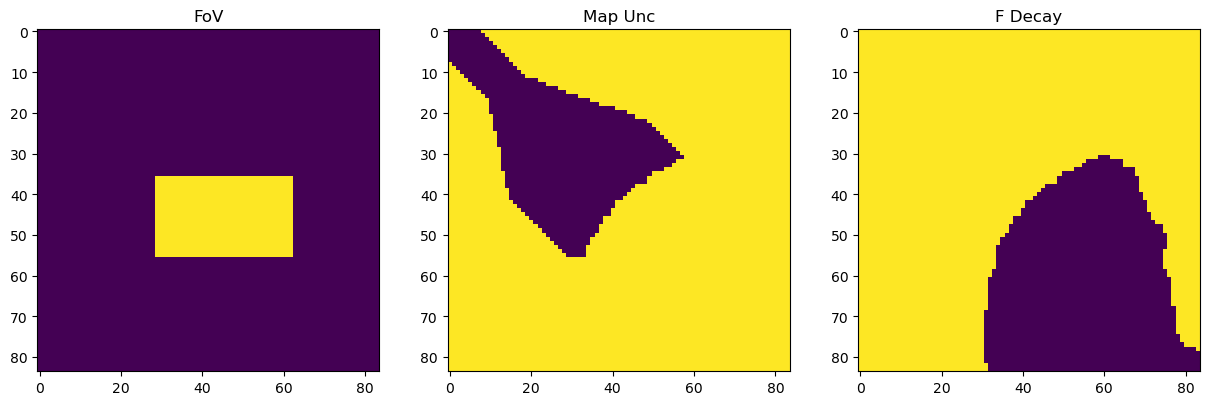

state: [46.         46.         24.         -6.92183615], reward: -6.921836147300301, new action: 


ValueError: operands could not be broadcast together with shapes (0,) (3,) 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

state = vec_env.reset()
reward = 0

while True:
    # Limpar a saída e plotar o estado atual
    clear_output(wait=True)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    axes[0].imshow(vec_env.render_state[:,:,1])
    axes[0].set_title('FoV')

    axes[1].imshow(vec_env.render_state[:,:,0])
    axes[1].set_title('Map Unc')

    axes[2].imshow(vec_env.f_decay)
    axes[2].set_title('F Decay')
    
    plt.show()

    # Ler o comando do teclado
    action = input("state: {}, reward: {}, new action: ".format(state,reward))
    action = [float(x) for x in action.split()]
    
    state, reward, done, _ = vec_env.step(action)
    print('reward :{}'.format(reward))

    

In [ ]:
action = '5 5 5'
action = action.replace(" ", "")
action = [float(action[0]),float(action[1]), float(action[2])]
print(action)

In [ ]:
action

In [ ]:
5 5 5
